<a href="https://colab.research.google.com/github/hyojunyee/kita_2404/blob/main/m8_VISION%20%EC%9D%91%EC%9A%A9/vision_05_OpenCV_03_0925.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
%cd /content/drive/MyDrive/kdt_240424/m8_vision

/content/drive/MyDrive/kdt_240424/m8_vision


In [24]:
from google.colab.patches import cv2_imshow

#### 오픈 연산 (cv2.MORPH_OPEN)
오픈 연산은 침식 연산(erode) 다음에 팽창 연산(dilate)을 수행하는 것으로 구성됩니다. 이 연산은 다음과 같은 효과를 가집니다:

- 작은 객체나 노이즈를 제거합니다.
- 두 객체 사이의 얇은 연결을 끊습니다.
- 객체의 경계를 부드럽게 합니다.

[ 연산 과정 ]
- 침식 연산: 커널이 위치한 모든 픽셀이 커널과 일치할 때만 원본 이미지의 중심 픽셀을 보존합니다. 이 과정에서 이미지의 작은 노이즈가 제거되고, 객체의 크기가 줄어듭니다.
- 팽창 연산: 커널과 하나라도 픽셀이 겹치는 경우, 원본 이미지의 중심 픽셀을 커널로 설정된 값으로 변경합니다. 침식에서 줄어든 객체의 크기가 다시 증가하면서, 노이즈는 제거된 상태를 유지합니다.

In [25]:
!pwd

/content/drive/MyDrive/kdt_240424/m8_vision


작업 Flow
- 이미지 전처리: 동전 이미지를 그레이스케일로 변환하고 블러링, 이진화를 통해 동전만 분리합니다.
- 윤곽선 검출: 전처리된 이미지에서 외곽선을 찾아 동전의 중심과 크기를 계산합니다.
- 원 그리기: 검출된 동전의 윤곽에 원을 그려 시각적으로 동전을 표시합니다.
- 결과 출력: 전처리된 이진화 이미지와 동전이 검출된 이미지를 Colab에서 출력합니다.

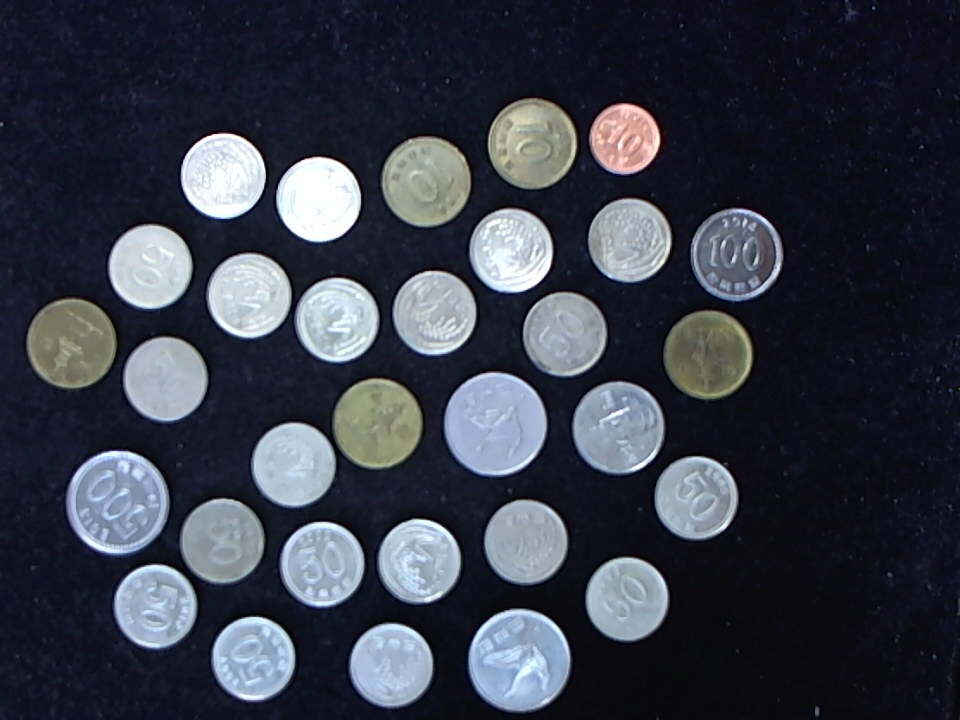

In [26]:
import cv2
import numpy as np

fname = '/content/drive/MyDrive/kdt_240424/m8_vision/data/coin/65.png'
img = cv2.imread(fname)
cv2_imshow(img)

Preprocessed Image


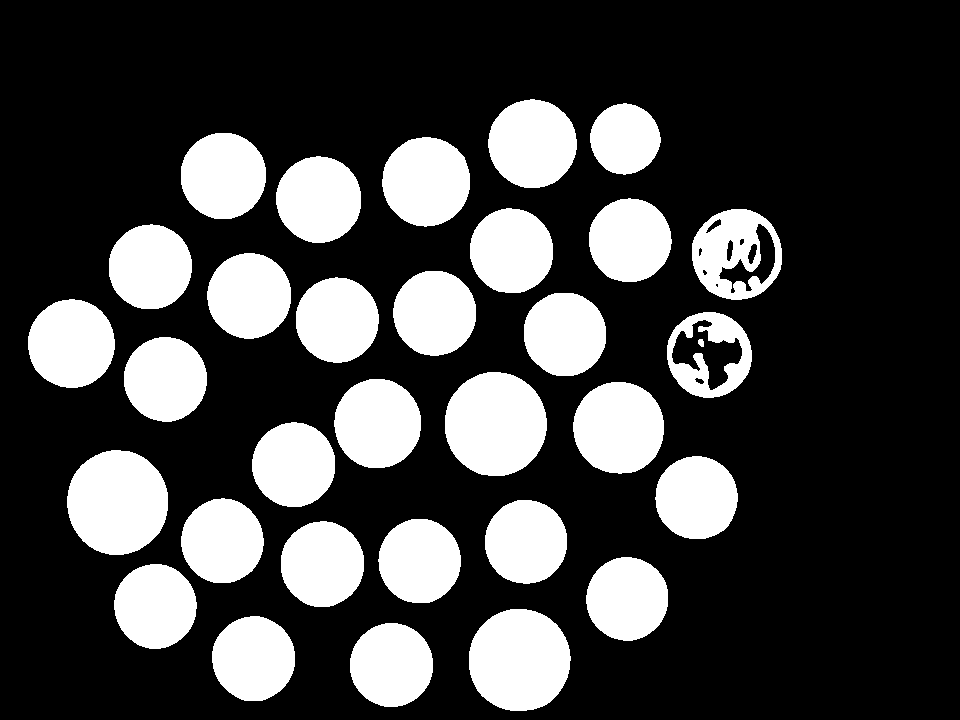

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 주어진 동전 영상 번호를 바탕으로 동전 영상을 읽고, 그레이스케일로 변환 후 블러링과 이진화를 수행한 후 오픈 연산을 통해 작은 노이즈를 제거
# 전처리 함수 만들기
def preprocessing(coin_no):
    fname = f"data/coin/{coin_no}.png"
    img = cv2.imread(fname, cv2.IMREAD_COLOR)   # 이미지 읽기
    if img is None: return None, None           # None이 두번 사용된 이유는 이 함수가 기본적으로 이미지 두개(img와 th_img)를 반환하기 때문

    # 1. 그레이 스케일로 변환
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. 그레이 스케일 이미지에 가우신 블러를 적용
    # 이미지의 노이즈를 줄이고, 세부적인 정보를 감소시킴, 이진화 과정에서 배경과 동전을 잘 구분하기 위해 필요
    blur = cv2.GaussianBlur(gray, (7, 7), 2, 2)     # X축과 y축 방향으로 표준편차가 각각 2인 7x7 크기의 가우시안 커널을 사용하여 gray 이미지에 블러를 적용함을 의미

    # 3. OTSU 알고리즘을 이용해 이진화를 수행
    # OTSU 알고리즘은 최적의 임계값을 자동으로 계산하고 이를 기반으로 이진화를 수행해줌.
    flag = cv2.THRESH_BINARY + cv2.THRESH_OTSU      # OTSU 알고리즘은 전체 이미지의 히스토그램을 분석하여, 전경(동전)과 배경을 구분하는 최적의 임계값을 찾음(사용자가 입력한 임계값 무시)
    # flag = cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU  # 이미지 색상 반전
    # 그 결과를 th_img에 저장
    _, th_img = cv2.threshold(blur, 130, 255, flag)   # 픽셀값이 130이상인 경우 MAXVAL 값(255)을 할당하고, 130 미만인 경우 0으로 설정
    # 3x3 크기의 구조 요소(커널)를 생성
    mask = np.ones((3, 3), np.uint8)

    # 4. 열림연산 수행
    # 이진화된 이미지에서 작은 노이즈나 객체를 제거하고, 떨어져 있는 객체를 더 명확하게 분리하는 등의 전처리를 수행(침식 후 팽창)
    th_img = cv2.morphologyEx(th_img, cv2.MORPH_OPEN, mask)

    return img, th_img

img, th_img = preprocessing(65)     # 전처리 수행
if img is None:   raise Exception("이미지 읽기 오류")

print("Preprocessed Image")
cv2_imshow(th_img)

OpenCV의 버전에 따라 cv2.findContours() 함수의 반환 값이 달라집니다.

- OpenCV 4.x: 반환 값은 (윤곽선 리스트, 계층 구조)로 되어 있으며, results[0]이 윤곽선 리스트입니다.
- OpenCV 3.x: 반환 값은 (수정된 이미지, 윤곽선 리스트)이며, 윤곽선 리스트는 results[1]입니다.

Coin Image


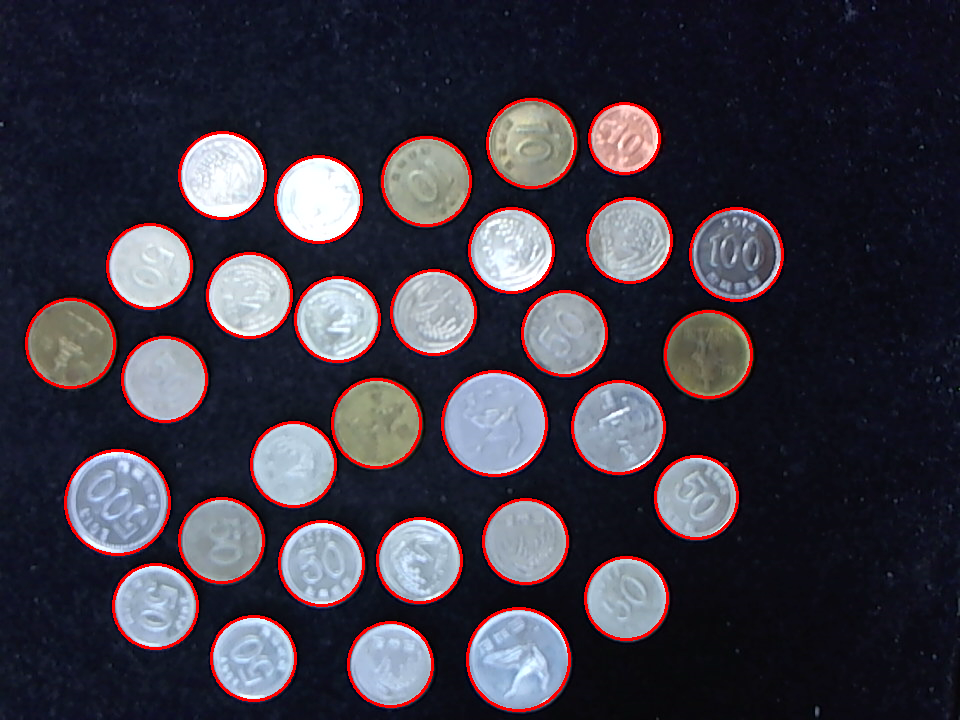

In [39]:
# 이미지에서 동전과 같은 원형 객체를 보다 효율적으로 검출하고, 노이즈로 인한 잘못된 검출을 최소화
def find_coins(img):
    # cv2.findCountours 함수는 이미지에서 윤곽선을 찾는 데 사용
    # cv2.RETR_EXTERNAL: 이 옵션은 이미지의 가장 바깥쪽 윤곽선만을 검출. 이는 각 동전의 외곽선만을 찾는데 적합.
    # cv2.CHAIN_APPROX_SIMPLE: 이 근사 방법은 유곽선을 구성하는 점들 중 필요한 점들만을 반환하여 메모리를 절약. 예를들어 직사각형의 경우 4개의 모서리 점
    result = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # OpenCV 4.x: 반환 값은 (윤곽선 리스트, 계층 구조)로 되어 있으며, results[0]이 윤곽선 리스트입니다.
    # OpenCV 3.x: 반환 값은 (수정된 이미지, 윤곽선 리스트)이며, 윤곽선 리스트는 results[1]입니다.
    countours = result[0] if int(cv2.__version__[0]) >= 4 else result[1]    # 윤곽선 리스트를 선택하기 위한 조건문

    # 리스트 생성 방식
    circles = [cv2.minEnclosingCircle(c) for c in countours]    # 주어진 점들의 집합(여기서는 윤곽선 c)을 모두 포함하는 가장 작은 원을 찾음
    circles = [(tuple(map(int, center)), int(radius))           # 원의 중심 좌표와 반지름을 정수형으로 변환
               for center, radius in circles if radius > 25]    # 각 원의 반지름이 25 픽셀보다 큰 경우에만 해당 원을 새로운 리스트에 포함
    return circles

# 감지된 각 동전의 중심 좌표와 반지름 정보를 담고있는 circles 리스트를 반환
circles = find_coins(th_img)
for center, radius in circles:
    # 각 동전의 중심, 반지름에 따라 원을 그림
    cv2.circle(img, center, radius, (0, 0, 255), 2)

print("Coin Image")
cv2_imshow(img)     # 첫번째 인자만 전달

- 마스크 생성: 각 동전의 중심과 반지름을 기준으로 흰색 원이 그려진 검정색 마스크를 생성합니다.
- 동전 영역 추출: 원본 이미지에서 해당 동전이 위치한 사각형 영역을 추출합니다.
- 비트 연산: 마스크를 사용하여 동전 부분만 남기고 나머지 부분은 제거합니다.
- 결과 출력: 마스크가 적용된 최종 동전 이미지를 출력합니다.

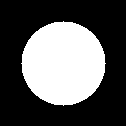

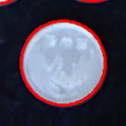

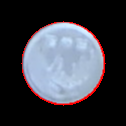

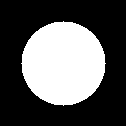

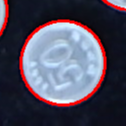

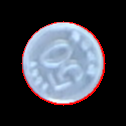

In [44]:
for center, radius in circles[0:2]:
    r = radius * 3
    cen = (r // 2, r // 2)  # 중심 좌표 설정
    mask = np.zeros((r,r,3), np.uint8)  # (r,r) 크기의 검정색 빈 마스크를 생성
    cv2.circle(mask, cen, radius,(255,255,255), cv2.FILLED) # 마스크에 흰색 원을 그림
    cv2_imshow(mask)
    print()
    coin = cv2.getRectSubPix(img, (r,r), center)    # 원본 이미지에서 동전이 위치한 사각형 영역이 추출
    cv2_imshow(coin)
    print()
    # 마스크의 흰색 영역은 동전의 픽셀 값을 그대로 유지 (x AND 255는 항상 x)
    # 마스크의 검은색 영역은 동전 영역 바깥의 픽셀 값을 모두 0으로 만들어 검은색으로 처리(x AND 0은 항상 0)
    coin = cv2.bitwise_and(coin, mask)
    cv2_imshow(coin)
    print()

이미지에서 동전과 같은 원형 객체를 추출

In [46]:
def make_coin_img(src, circles):
    coins = []
    for center, radius in circles:
        r = radius * 3
        cen = (r // 2, r // 2)  # 검출 동전 반지름의 3배. 동전을 추출하는 과정에서 동전 그림이 온전히 포함 될 수 있도록 충분한 크기의 마스크를 생성
        mask = np.zeros((r,r,3), np.uint8)  # 마스크의 중심. 이미지의 가로와 세로 길이의 절반 위치가 정확히 이미지의 중앙
        # 주어진 중심, 반지름, 색상, 채우기 옵션을 사용, 마스크 이미지 위에 흰색으로 채워진 원을 그림.
        cv2.circle(mask, cen, radius,(255,255,255), cv2.FILLED)

        # 동전 가져오기
        coin = cv2.getRectSubPix(img, (r,r), center)    # 원본이미지에서 동전이 위치한 사각형 영역 추출
        # 마스크에서 흰색으로 표시된 부분(즉, 동전 영역)만이 결과 이미지에 남게 되고, 나머지 배경은 검은색(값이 0)으로 설정
        coin = cv2.bitwise_and(coin, mask)              # 마스킹 처리. coin이미지와 mask 이미지간의 비트 단위 AND 연산을 수행
        coin.append(coin)                               # 동전 이미지 저장
        # cv2_imshow("mask_" + str(center), mask)         # 마스크 이미지 보기
    return coins

각 동전의 HSV 색상 히스토그램을 계산하는 과정을 수행

In [48]:
def calc_histo_hue(coin):
    hsv = cv2.cvtColor(coin, cv2.COLOR_BGR2HSV)     # 컬러 공간 변환
    hsize, ranges = [32], [0,180]                   # 32개의 빈을 사용하여 색상 범위를 나누고 HSV에서 색상 값은 0에서 179사이
    hist = cv2.calcHist([hsv], [0], hsize, ranges)  # 0은 HSV 이미지의 첫번째 채널, 즉 색상(Heu) 채널을 의미, hsize: 각 차원별 빈(bin)의 개수
    return hist.flatten()                           # 차원 히스토그램을 1차원 배열로 변환하여 반환

색상 팔레트 생성 함수(make_palate)

In [49]:
def make_palate(rows):
    hue = [round(i*180/rows) for i in range(rows)]  # 전체 hue 범위를 rows의 수만큼 균일하게 나누어 각 hue 값을 계산, hue 값의 범위는 일반적으로 0에서 180까지
    hsv = [[(h, 255, 255)] for h in hue]            # 계산된 hue 값에 대해 채도(Saturation)와 명도(Value)를 최대값인 255로 설정하게 하여 HSV 색상을 생성
    hsv = np.array(hsv, np.uint8)                   # numpy 행렬의 uint8형 변환
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)     # HSV 컬러 -> BGR 컬러

히스토그램 계산 및 시각화

In [ ]:
import matplotlib.pyplot as plt

